In [ ]:
#| default_exp data

In [ ]:
#| hide
from nbdev.showdoc import *

# data
> This module will contain the TTSDataset and the collate function used in training

In [ ]:
#| export
from fastspeech.loading import *
from fastspeech.preprocess import *
from torch.utils.data import Dataset, DataLoader
from torch import tensor
import torch
from functools import partial
from fastcore.foundation import L

In [ ]:
#| hide
from fastspeech.visualize import *

In [ ]:
#| export
class TTSDataset(Dataset):
    def __init__(self, 
                 path_data: str, 
                 path_vocab: str, 
                 Norm, # A Normalization class
                 sr: int=22050, # Sampling rate
                 n_fft: int=1024, # Length of the windowed signal
                 hl: int=256, # The hop length
                 nb: int=80, # Number of mel bins
                 ds: slice=slice(None), # The data slice
                 stats: dict={}, # Statistics dictionary for preprocessing
                 preload: bool=False): # Loads dataset on initilzation
        
        self.preload = preload
        self.stats = stats
        
        replace_to_tg = partial(replace_extension, extension=".TextGrid")
        self.load_audio = partial(load_audio, sr=sr)
        self.melspectrogram = partial(melspectrogram, n_fft=n_fft, hl=hl, nb=nb)
        self.get_phones_and_durations = partial(get_phones_and_durations, sr=sr, hl=hl)
        self.norm = Norm(**stats)
        
        self.files = get_audio_files(path_data)[ds]
        self.files_tg = self.files.map(replace_to_tg)
        
        self.vocab = Vocab(path_vocab, ["spn"])
        
        self.pho_transform = [partial(phones_list_to_num, vocab=self.vocab)]
        self.wav_transfom = [partial(trim_audio, top_db=self.stats["top_db"], 
                             n_fft=n_fft, hl=hl)]
        self.mel_tranform = [self.norm.normalize]
        
        
        if preload:
            self.wavs = self.files.map(self.load_audio)
            self.wavs = self.wavs.map(partial(transform_inp, 
                                              transform_list=self.wav_transfom))
            
            self.phones, self.durations = zip(*self.files_tg.map(
                                              self.get_phones_and_durations))
            
            self.phones = map_tensors(transform_inp(self.phones, self.pho_transform))
            
            self.mels = map_tensors(self.wavs.map(self.melspectrogram).map(
                        transform_inp, transform_list=self.mel_tranform))
            mel_lens = list(map(lambda x: x.shape[-1], self.mels))
            
            self.durations = [round_and_align_durations(d, mel_lens[i]) 
                              for i, d in enumerate(map_tensors(self.durations))]
    def __getitem__(self, idx):
        if self.preload:
            return self.phones[idx], self.durations[idx], self.mels[idx]
        
        wav = transform_inp(self.load_audio(self.files[0]), self.wav_transfom)
        mel = tensor(transform_inp(self.melspectrogram(wav), self.mel_tranform))
        
        phones, duration = self.get_phones_and_durations(self.files_tg[idx])
        phones = tensor(transform_inp(phones, self.pho_transform)).squeeze()

        duration = round_and_align_durations(tensor(duration), mel.shape[-1])
        
        return phones, duration, mel
    
    def __len__(self):
        return len(self.files)

In [ ]:
#| hide
path = "../sample_data"
path_vocab = "../sample_data/cmudict-0.7b.symbols.txt"

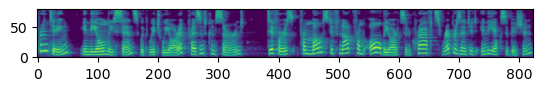

(torch.Size([108]), torch.Size([108]), torch.Size([80, 824]))

In [ ]:
ds = TTSDataset(path, path_vocab, ZScoreNormalization, preload=True,
                stats={'max_val': 100., 'min_val': .01, "mean": 0.01, 
                       "std": 0.20, "top_db": 35})

phones, duration, mel = ds[0]
show_mel(ds.norm.denormalize(mel))
phones.shape, duration.shape, mel.shape

In [ ]:
#| export
def compute_statistics(data: list[tensor]):
    flat = flatten_and_concat(data)
    return {"min_val": flat.min(), "max_val": flat.max(), 
            "mean": flat.mean(), "std": flat.std()}

In [ ]:
stats = compute_statistics(ds.mels)
stats

{'min_val': -0.04999999,
 'max_val': 2457.7344,
 'mean': 2.4844525,
 'std': 26.82147}

In [ ]:
#| export
def collate_fn(inp, pad_num: int, norm):
    phones, durations, mels = zip(*inp)
    norm_zero = norm.normalize(0)
    
    mel_batched = pad_mels(mels, norm_zero)
    phones_batched = pad_phones(pad_max_seq(phones), pad_num)
    mel_len = mel_batched.shape[-1]
    
    duration_batched = pad_duration(pad_max_seq(durations), mel_batched.shape[-1])
    
    assert phones_batched.shape == duration_batched.shape
    assert len(duration_batched.sum(dim=1).unique()) == 1
    return phones_batched, duration_batched, mel_batched

In [ ]:
dl = DataLoader(ds, 2, collate_fn=partial(collate_fn, pad_num=ds.vocab.pad_num, 
                                          norm=ds.norm))

for phones, durations, mels in dl: break
phones.shape, durations.shape, mels.shape

(torch.Size([2, 109]), torch.Size([2, 109]), torch.Size([2, 80, 824]))

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()